In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor


# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib
import matplotlib.pyplot as plt
# 한글 처리
from matplotlib import rc, font_manager
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/NanumGothicCoding.ttf').get_name()
rc('font',family=font_name)

# - 마이너스 사인 처리
matplotlib.rcParams['axes.unicode_minus'] = False

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula


#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
lv_grouped = lv_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_lv_grouped = lv_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# '제모제'만 빼서 df생성
item = '제모제'
grouped_by = 'date'
day_lv_grouped_w_item = pd.merge(day_lv_grouped.loc[day_lv_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_lv_grouped_w_sns_item = pd.merge(day_lv_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
lv_day_w = day_lv_grouped_w_sns_item[selected_cols]

## 모든 변수 - 날씨 소셜 전부

In [5]:
# train_data = lv_day_w.loc[lv_day_w.date.between('2016-01-01','2017-12-31')]
# test_data = lv_day_w.loc[lv_day_w.date.between('2018-01-01','2018-12-31')]

# # train_data.describe() # 731일
# # test_data.describe() # 365일

# # 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# combined = lv_day_w.loc[:,'temp':]
# target = lv_day_w.loc[:,'qty']

##### 날씨 소셜 전부 사용할 시 : 폭망 

# 날씨만 

In [6]:
list_col = ['temp', 'cloud', 'wind', 'lgt_time','snow', 'rain','PM10']
lowVIF(w,15,list_col)

,VIF_Factor,features
0,1.047669,snow
1,1.305399,rain
2,3.867186,temp
3,4.765719,PM10
4,6.540650,cloud
5,8.176526,lgt_time
6,8.996828,wind


In [7]:
# list_col = ['temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
#               'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',]
lv_day_w = lv_day_w[['date','qty']+list_col].groupby('date').mean().reset_index()
# gs_week_w.tail(2)

train_data = lv_day_w.loc[lv_day_w.date.between('2016-01-01','2017-12-31')]
test_data = lv_day_w.loc[lv_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
combined = lv_day_w.loc[:,'temp':'PM10']
target = lv_day_w.loc[:,'qty']

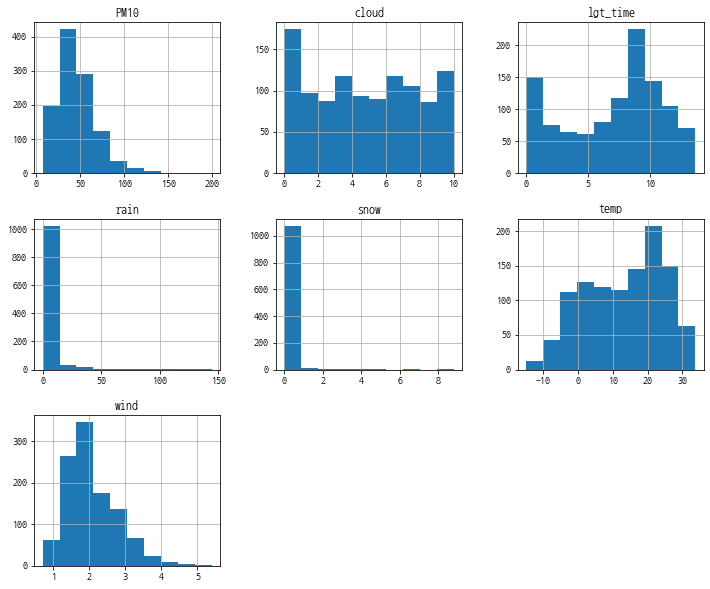

In [8]:
combined = combined
combined.hist(figsize = (12,10))
plt.show()

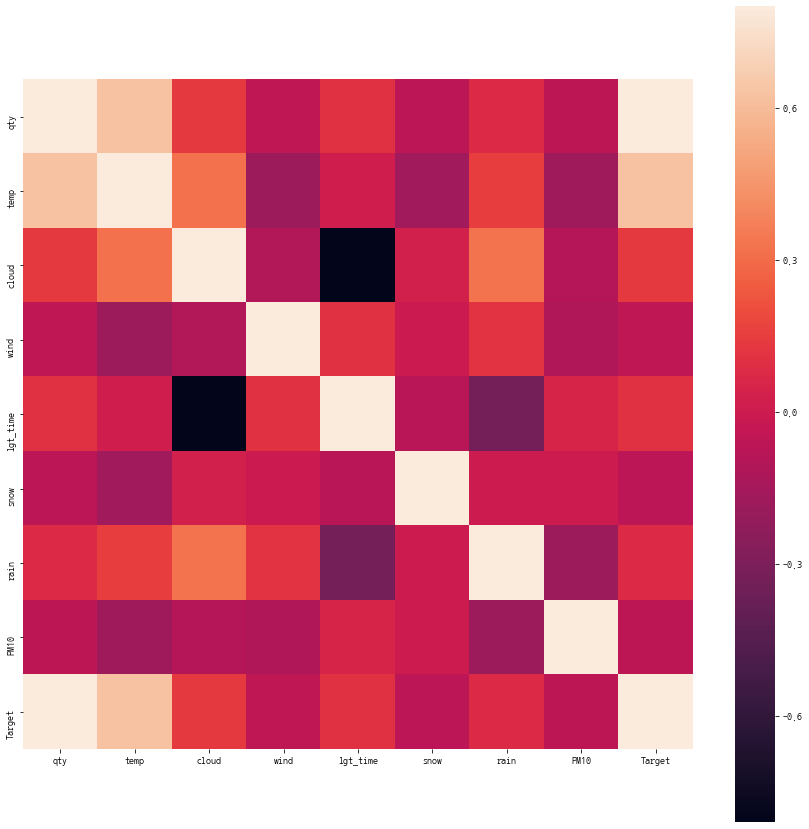

In [48]:
train_data = train_data
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [49]:
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 7)

In [50]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


#### =========='xxxxxxxyyyyyzzzzz.hdf5'파일이 안주어지면 실행.(있으면 실행 필요없음)==========

In [51]:
checkpoint_name = 'LV(lowVIF07)-'+item+grouped_by+'-Weigh-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [13]:
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0718 10:39:36.752459  4412 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0718 10:39:36.863228  4412 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/500
585/585 [==============================] - 0s 532us/step - loss: 1589.0113 - mean_absolute_error: 1589.0113 - val_loss: 793.6490 - val_mean_absolute_error: 793.6490

Epoch 00001: val_loss improved from inf to 793.64905, saving model to LV(lowVIF07)-제모제date-Weigh-001--793.64905.hdf5
Epoch 2/500
585/585 [==============================] - 0s 80us/step - loss: 1199.3466 - mean_absolute_error: 1199.3466 - val_loss: 576.5571 - val_mean_absolute_error: 576.5571

Epoch 00002: val_loss improved from 793.64905 to 576.55707, saving model to LV(lowVIF07)-제모제date-Weigh-002--576.55707.hdf5
Epoch 3/500
585/585 [==============================] - 0s 77us/step - loss: 926.9652 - mean_absolute_error: 926.9652 - val_loss: 527.8093 - val_mean_absolute_error: 527.8093

Epoch 00003: val_loss improved from 576.55707 to 527.80927, saving model to LV(lowVIF07)-제모제date-Weigh-003--527.80927.hdf5
Epoch 4/500
585/585 [==============================] - 0s 80u


Epoch 00035: val_loss did not improve from 527.80927
Epoch 36/500
585/585 [==============================] - 0s 106us/step - loss: 661.5659 - mean_absolute_error: 661.5659 - val_loss: 646.2854 - val_mean_absolute_error: 646.2854

Epoch 00036: val_loss did not improve from 527.80927
Epoch 37/500
585/585 [==============================] - 0s 88us/step - loss: 663.7271 - mean_absolute_error: 663.7271 - val_loss: 611.3279 - val_mean_absolute_error: 611.3279

Epoch 00037: val_loss did not improve from 527.80927
Epoch 38/500
585/585 [==============================] - 0s 113us/step - loss: 655.7862 - mean_absolute_error: 655.7862 - val_loss: 648.7434 - val_mean_absolute_error: 648.7434

Epoch 00038: val_loss did not improve from 527.80927
Epoch 39/500
585/585 [==============================] - 0s 97us/step - loss: 658.6127 - mean_absolute_error: 658.6127 - val_loss: 652.4147 - val_mean_absolute_error: 652.4147

Epoch 00039: val_loss did not improve from 527.80927
Epoch 40/500
585/585 [======


Epoch 00071: val_loss did not improve from 527.80927
Epoch 72/500
585/585 [==============================] - 0s 82us/step - loss: 646.3947 - mean_absolute_error: 646.3947 - val_loss: 707.1061 - val_mean_absolute_error: 707.1061

Epoch 00072: val_loss did not improve from 527.80927
Epoch 73/500
585/585 [==============================] - 0s 78us/step - loss: 650.3967 - mean_absolute_error: 650.3967 - val_loss: 662.4330 - val_mean_absolute_error: 662.4330

Epoch 00073: val_loss did not improve from 527.80927
Epoch 74/500
585/585 [==============================] - 0s 82us/step - loss: 634.0092 - mean_absolute_error: 634.0092 - val_loss: 613.4201 - val_mean_absolute_error: 613.4201

Epoch 00074: val_loss did not improve from 527.80927
Epoch 75/500
585/585 [==============================] - 0s 82us/step - loss: 634.4581 - mean_absolute_error: 634.4581 - val_loss: 632.0215 - val_mean_absolute_error: 632.0215

Epoch 00075: val_loss did not improve from 527.80927
Epoch 76/500
585/585 [========


Epoch 00107: val_loss did not improve from 527.80927
Epoch 108/500
585/585 [==============================] - 0s 92us/step - loss: 624.3987 - mean_absolute_error: 624.3987 - val_loss: 666.1738 - val_mean_absolute_error: 666.1738

Epoch 00108: val_loss did not improve from 527.80927
Epoch 109/500
585/585 [==============================] - 0s 92us/step - loss: 631.7332 - mean_absolute_error: 631.7332 - val_loss: 704.9271 - val_mean_absolute_error: 704.9271

Epoch 00109: val_loss did not improve from 527.80927
Epoch 110/500
585/585 [==============================] - 0s 84us/step - loss: 620.7766 - mean_absolute_error: 620.7766 - val_loss: 631.0449 - val_mean_absolute_error: 631.0449

Epoch 00110: val_loss did not improve from 527.80927
Epoch 111/500
585/585 [==============================] - 0s 87us/step - loss: 621.5022 - mean_absolute_error: 621.5022 - val_loss: 699.3146 - val_mean_absolute_error: 699.3146

Epoch 00111: val_loss did not improve from 527.80927
Epoch 112/500
585/585 [===

585/585 [==============================] - 0s 103us/step - loss: 603.2301 - mean_absolute_error: 603.2301 - val_loss: 674.1961 - val_mean_absolute_error: 674.1961

Epoch 00143: val_loss did not improve from 517.44666
Epoch 144/500
585/585 [==============================] - 0s 107us/step - loss: 610.1468 - mean_absolute_error: 610.1468 - val_loss: 650.0124 - val_mean_absolute_error: 650.0124

Epoch 00144: val_loss did not improve from 517.44666
Epoch 145/500
585/585 [==============================] - 0s 118us/step - loss: 604.2232 - mean_absolute_error: 604.2232 - val_loss: 600.4445 - val_mean_absolute_error: 600.4445

Epoch 00145: val_loss did not improve from 517.44666
Epoch 146/500
585/585 [==============================] - 0s 113us/step - loss: 603.0441 - mean_absolute_error: 603.0441 - val_loss: 591.4830 - val_mean_absolute_error: 591.4830

Epoch 00146: val_loss did not improve from 517.44666
Epoch 147/500
585/585 [==============================] - 0s 123us/step - loss: 623.1342 - 


Epoch 00178: val_loss did not improve from 517.44666
Epoch 179/500
585/585 [==============================] - 0s 125us/step - loss: 587.7426 - mean_absolute_error: 587.7426 - val_loss: 633.7922 - val_mean_absolute_error: 633.7922

Epoch 00179: val_loss did not improve from 517.44666
Epoch 180/500
585/585 [==============================] - 0s 122us/step - loss: 586.6268 - mean_absolute_error: 586.6268 - val_loss: 604.4555 - val_mean_absolute_error: 604.4555

Epoch 00180: val_loss did not improve from 517.44666
Epoch 181/500
585/585 [==============================] - 0s 119us/step - loss: 592.2430 - mean_absolute_error: 592.2430 - val_loss: 615.6379 - val_mean_absolute_error: 615.6379

Epoch 00181: val_loss did not improve from 517.44666
Epoch 182/500
585/585 [==============================] - 0s 123us/step - loss: 591.4598 - mean_absolute_error: 591.4598 - val_loss: 611.7697 - val_mean_absolute_error: 611.7697

Epoch 00182: val_loss did not improve from 517.44666
Epoch 183/500
585/585 

585/585 [==============================] - 0s 142us/step - loss: 596.8831 - mean_absolute_error: 596.8831 - val_loss: 556.5209 - val_mean_absolute_error: 556.5209

Epoch 00214: val_loss did not improve from 517.44666
Epoch 215/500
585/585 [==============================] - 0s 132us/step - loss: 603.2221 - mean_absolute_error: 603.2221 - val_loss: 731.7159 - val_mean_absolute_error: 731.7159

Epoch 00215: val_loss did not improve from 517.44666
Epoch 216/500
585/585 [==============================] - 0s 136us/step - loss: 604.0377 - mean_absolute_error: 604.0377 - val_loss: 690.4678 - val_mean_absolute_error: 690.4678

Epoch 00216: val_loss did not improve from 517.44666
Epoch 217/500
585/585 [==============================] - 0s 130us/step - loss: 578.7472 - mean_absolute_error: 578.7472 - val_loss: 626.1053 - val_mean_absolute_error: 626.1053

Epoch 00217: val_loss did not improve from 517.44666
Epoch 218/500
585/585 [==============================] - 0s 127us/step - loss: 574.0227 - 


Epoch 00249: val_loss did not improve from 517.44666
Epoch 250/500
585/585 [==============================] - 0s 163us/step - loss: 562.3638 - mean_absolute_error: 562.3638 - val_loss: 725.6513 - val_mean_absolute_error: 725.6513

Epoch 00250: val_loss did not improve from 517.44666
Epoch 251/500
585/585 [==============================] - 0s 154us/step - loss: 574.7333 - mean_absolute_error: 574.7333 - val_loss: 510.3370 - val_mean_absolute_error: 510.3370

Epoch 00251: val_loss improved from 517.44666 to 510.33703, saving model to LV(lowVIF07)-제모제date-Weigh-251--510.33703.hdf5
Epoch 252/500
585/585 [==============================] - 0s 123us/step - loss: 600.9296 - mean_absolute_error: 600.9296 - val_loss: 625.6368 - val_mean_absolute_error: 625.6368

Epoch 00252: val_loss did not improve from 510.33703
Epoch 253/500
585/585 [==============================] - 0s 131us/step - loss: 558.4001 - mean_absolute_error: 558.4001 - val_loss: 550.9625 - val_mean_absolute_error: 550.9625

Epoch

585/585 [==============================] - 0s 165us/step - loss: 564.3166 - mean_absolute_error: 564.3166 - val_loss: 524.6929 - val_mean_absolute_error: 524.6929

Epoch 00285: val_loss did not improve from 510.33703
Epoch 286/500
585/585 [==============================] - 0s 136us/step - loss: 545.0118 - mean_absolute_error: 545.0118 - val_loss: 618.4546 - val_mean_absolute_error: 618.4546

Epoch 00286: val_loss did not improve from 510.33703
Epoch 287/500
585/585 [==============================] - 0s 142us/step - loss: 532.8605 - mean_absolute_error: 532.8605 - val_loss: 649.9356 - val_mean_absolute_error: 649.9356

Epoch 00287: val_loss did not improve from 510.33703
Epoch 288/500
585/585 [==============================] - 0s 154us/step - loss: 543.8880 - mean_absolute_error: 543.8880 - val_loss: 648.5491 - val_mean_absolute_error: 648.5491

Epoch 00288: val_loss did not improve from 510.33703
Epoch 289/500
585/585 [==============================] - 0s 158us/step - loss: 541.7553 - 

585/585 [==============================] - 0s 126us/step - loss: 532.1657 - mean_absolute_error: 532.1657 - val_loss: 639.8231 - val_mean_absolute_error: 639.8231

Epoch 00320: val_loss did not improve from 501.13252
Epoch 321/500
585/585 [==============================] - 0s 121us/step - loss: 521.4939 - mean_absolute_error: 521.4939 - val_loss: 559.3279 - val_mean_absolute_error: 559.3279

Epoch 00321: val_loss did not improve from 501.13252
Epoch 322/500
585/585 [==============================] - 0s 128us/step - loss: 550.3262 - mean_absolute_error: 550.3262 - val_loss: 719.4793 - val_mean_absolute_error: 719.4793

Epoch 00322: val_loss did not improve from 501.13252
Epoch 323/500
585/585 [==============================] - 0s 138us/step - loss: 534.4368 - mean_absolute_error: 534.4368 - val_loss: 563.2870 - val_mean_absolute_error: 563.2870

Epoch 00323: val_loss did not improve from 501.13252
Epoch 324/500
585/585 [==============================] - 0s 128us/step - loss: 518.6431 - 

585/585 [==============================] - 0s 162us/step - loss: 590.4690 - mean_absolute_error: 590.4690 - val_loss: 776.8774 - val_mean_absolute_error: 776.8774

Epoch 00355: val_loss did not improve from 501.13252
Epoch 356/500
585/585 [==============================] - 0s 148us/step - loss: 538.2349 - mean_absolute_error: 538.2349 - val_loss: 592.5058 - val_mean_absolute_error: 592.5058

Epoch 00356: val_loss did not improve from 501.13252
Epoch 357/500
585/585 [==============================] - 0s 152us/step - loss: 529.4075 - mean_absolute_error: 529.4075 - val_loss: 688.0962 - val_mean_absolute_error: 688.0962

Epoch 00357: val_loss did not improve from 501.13252
Epoch 358/500
585/585 [==============================] - 0s 142us/step - loss: 518.2840 - mean_absolute_error: 518.2840 - val_loss: 591.2113 - val_mean_absolute_error: 591.2113

Epoch 00358: val_loss did not improve from 501.13252
Epoch 359/500
585/585 [==============================] - 0s 135us/step - loss: 509.0302 - 

585/585 [==============================] - 0s 142us/step - loss: 506.1241 - mean_absolute_error: 506.1241 - val_loss: 673.1659 - val_mean_absolute_error: 673.1659

Epoch 00390: val_loss did not improve from 501.13252
Epoch 391/500
585/585 [==============================] - 0s 165us/step - loss: 497.6640 - mean_absolute_error: 497.6640 - val_loss: 660.9190 - val_mean_absolute_error: 660.9190

Epoch 00391: val_loss did not improve from 501.13252
Epoch 392/500
585/585 [==============================] - 0s 205us/step - loss: 513.2643 - mean_absolute_error: 513.2643 - val_loss: 579.8366 - val_mean_absolute_error: 579.8366

Epoch 00392: val_loss did not improve from 501.13252
Epoch 393/500
585/585 [==============================] - 0s 184us/step - loss: 498.2829 - mean_absolute_error: 498.2829 - val_loss: 615.5961 - val_mean_absolute_error: 615.5961

Epoch 00393: val_loss did not improve from 501.13252
Epoch 394/500
585/585 [==============================] - 0s 181us/step - loss: 502.3756 - 

585/585 [==============================] - 0s 150us/step - loss: 494.0105 - mean_absolute_error: 494.0105 - val_loss: 582.3366 - val_mean_absolute_error: 582.3366

Epoch 00425: val_loss did not improve from 501.13252
Epoch 426/500
585/585 [==============================] - 0s 145us/step - loss: 492.7276 - mean_absolute_error: 492.7276 - val_loss: 560.7723 - val_mean_absolute_error: 560.7723

Epoch 00426: val_loss did not improve from 501.13252
Epoch 427/500
585/585 [==============================] - 0s 159us/step - loss: 508.6017 - mean_absolute_error: 508.6017 - val_loss: 683.1189 - val_mean_absolute_error: 683.1189

Epoch 00427: val_loss did not improve from 501.13252
Epoch 428/500
585/585 [==============================] - 0s 164us/step - loss: 499.8231 - mean_absolute_error: 499.8231 - val_loss: 598.1218 - val_mean_absolute_error: 598.1218

Epoch 00428: val_loss did not improve from 501.13252
Epoch 429/500
585/585 [==============================] - 0s 136us/step - loss: 495.5063 - 

585/585 [==============================] - 0s 142us/step - loss: 486.9122 - mean_absolute_error: 486.9122 - val_loss: 595.3253 - val_mean_absolute_error: 595.3253

Epoch 00460: val_loss did not improve from 498.65170
Epoch 461/500
585/585 [==============================] - 0s 126us/step - loss: 466.8661 - mean_absolute_error: 466.8661 - val_loss: 661.4521 - val_mean_absolute_error: 661.4521

Epoch 00461: val_loss did not improve from 498.65170
Epoch 462/500
585/585 [==============================] - 0s 124us/step - loss: 499.7896 - mean_absolute_error: 499.7896 - val_loss: 581.1605 - val_mean_absolute_error: 581.1605

Epoch 00462: val_loss did not improve from 498.65170
Epoch 463/500
585/585 [==============================] - 0s 143us/step - loss: 473.2804 - mean_absolute_error: 473.2804 - val_loss: 594.0878 - val_mean_absolute_error: 594.0878

Epoch 00463: val_loss did not improve from 498.65170
Epoch 464/500
585/585 [==============================] - 0s 133us/step - loss: 494.9333 - 


Epoch 00495: val_loss did not improve from 498.65170
Epoch 496/500
585/585 [==============================] - 0s 126us/step - loss: 485.0095 - mean_absolute_error: 485.0095 - val_loss: 463.1358 - val_mean_absolute_error: 463.1358

Epoch 00496: val_loss improved from 498.65170 to 463.13584, saving model to LV(lowVIF07)-제모제date-Weigh-496--463.13584.hdf5
Epoch 497/500
585/585 [==============================] - 0s 134us/step - loss: 519.7742 - mean_absolute_error: 519.7742 - val_loss: 533.2137 - val_mean_absolute_error: 533.2137

Epoch 00497: val_loss did not improve from 463.13584
Epoch 498/500
585/585 [==============================] - 0s 124us/step - loss: 474.8766 - mean_absolute_error: 474.8766 - val_loss: 665.9331 - val_mean_absolute_error: 665.9331

Epoch 00498: val_loss did not improve from 463.13584
Epoch 499/500
585/585 [==============================] - 0s 119us/step - loss: 455.2667 - mean_absolute_error: 455.2667 - val_loss: 674.8044 - val_mean_absolute_error: 674.8044

Epoch

#### ====================================================================================================

In [110]:
# Load wights file of the best model :
wights_file = 'LV(lowVIF07)-제모제week-Weights-010--296.19345.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [111]:
train_X, val_X, train_y, val_y = train_test_split(train, target[:cut_line], test_size = 0.25, random_state = 14)

In [112]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
RFpredicted = model.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest validation MAE = ', MAE)
print('훈련세트점수 : {:.2f}'.format(model.score(train_X, train_y)))
print('검증세트점수 : {:.2f}'.format(model.score(val_X, val_y)))

Random forest validation MAE =  699.191256830601
훈련세트점수 : 0.90
검증세트점수 : 0.40


In [113]:
XGBModel = XGBRegressor(objective='reg:squarederror')
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)
print('훈련세트점수 : {:.2f}'.format(XGBModel.score(train_X, train_y)))
print('검증세트점수 : {:.2f}'.format(XGBModel.score(val_X, val_y)))

XGBoost validation MAE =  666.7769160869994
훈련세트점수 : 0.79
검증세트점수 : 0.44


In [114]:
combined = lv_day_w.loc[:,'temp':]
# combined = lv_day_w.loc[:,'temp':'PM25']
target = lv_day_w.loc[:,'qty']
RFpredicted = model.predict(combined)
XGBpredictions = XGBModel.predict(combined)
predictions = NN_model.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = lv_day_w['date']
result_df['qty'] = lv_day_w.loc[:,'qty']
# print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions
# print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted
# print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

In [117]:
df_graph = result_df.loc[:,['date','keras_qty','rf_qty','xgb_qty','qty']]
df_graph['date'] = pd.to_datetime(df_graph['date'])

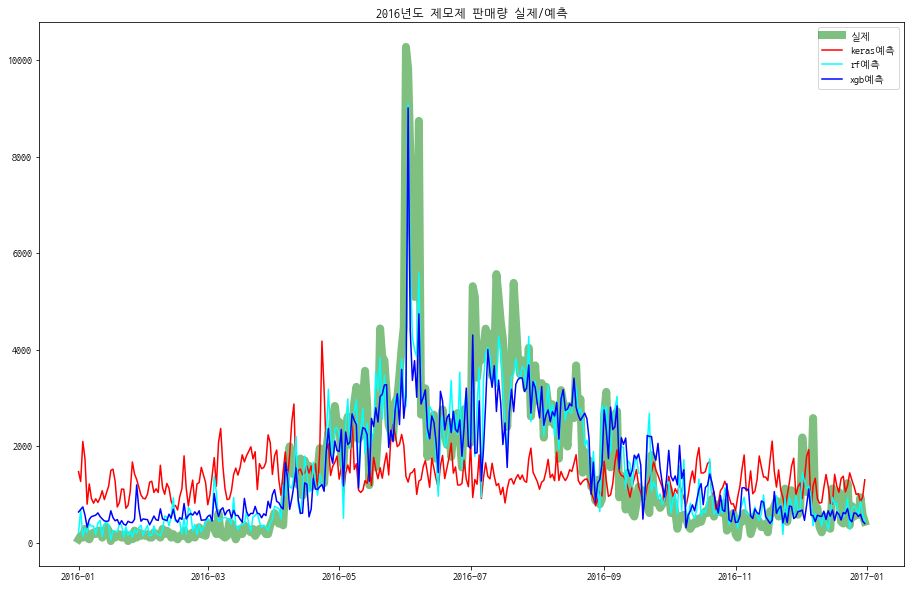

In [118]:
# 2016
df_graph = result_df.loc[result_df.date.between('2016-01-01','2016-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.date,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.date,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.legend()
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016',item ))
plt.show()

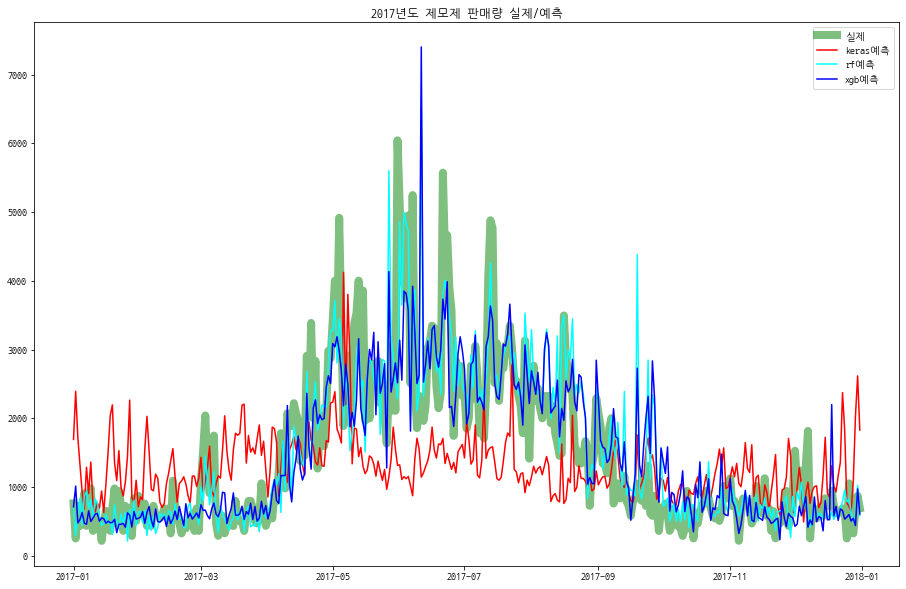

In [119]:
# 2017
df_graph = result_df.loc[result_df.date.between('2017-01-01','2017-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.date,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.date,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2017',item ))
plt.legend()
plt.show()

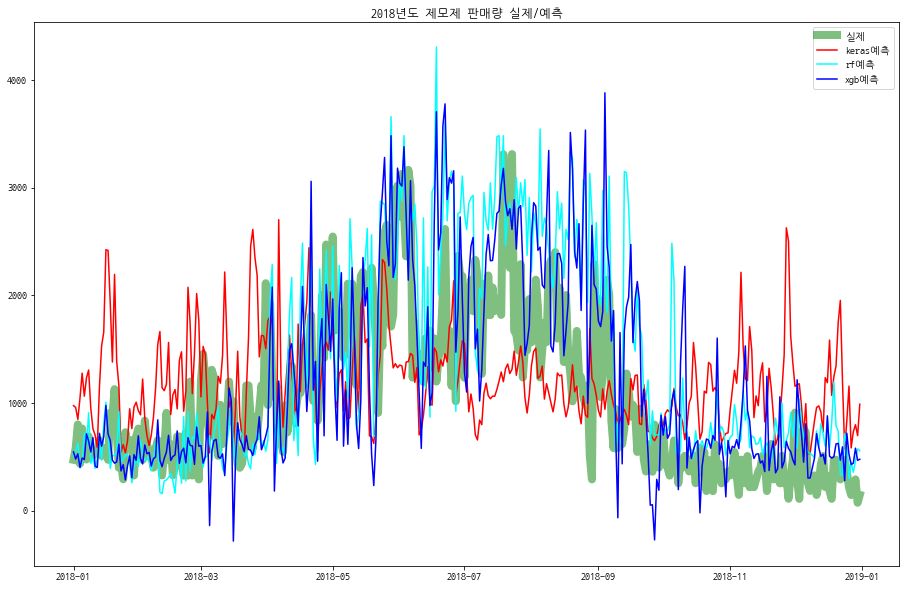

In [120]:
# 2018
df_graph = result_df.loc[result_df.date.between('2018-01-01','2018-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(df_graph.date,df_graph.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(df_graph.date,df_graph.xgb_qty, ls='-', label='xgb예측', color='b')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2018',item ))
plt.legend()
plt.show()

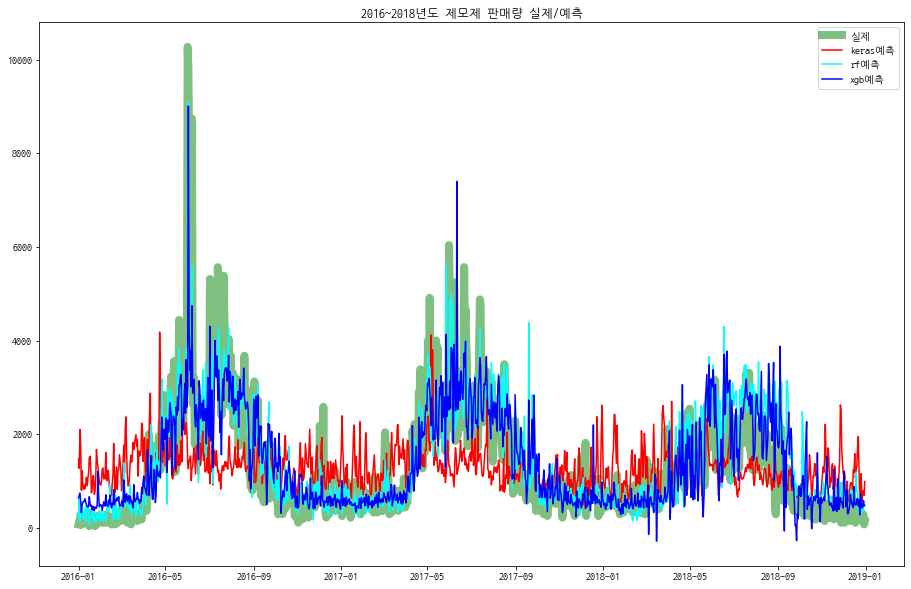

In [121]:
# 2016~2018
plt.figure(figsize=(15.5, 10))
plt.plot(result_df.date,result_df.qty, ls='-', label='실제', color='green', alpha=0.5, lw=8)
plt.plot(result_df.date,result_df.keras_qty, ls='-', label='keras예측', color='r')
plt.plot(result_df.date,result_df.rf_qty, ls='-', label='rf예측', color='cyan')
plt.plot(result_df.date,result_df.xgb_qty, ls='-', label='xgb예측', color='b')
plt.title('{}년도 {} 판매량 실제/예측'.format( '2016~2018',item ))
plt.legend()
plt.show()

In [123]:
def r2_score(v_true, v_pred):
    ssres = np.sum(np.square(v_pred - np.mean(v_true)))
    sstot = np.sum(np.square(v_true - np.mean(v_true)))
    return (1 - ssres / sstot)

print('RF R2값  \t: ','{:<.5f}'.format(r2_score(qty, RFpredicted)) )

print('XGB R2값  \t: ','{:<.5f}'.format(r2_score(qty, XGBpredictions)) )

print('KerasNN R2값\t: ','{:<.5f}'.format(r2_score(qty,predictions )) )

RF R2값  	:  0.12958
XGB R2값  	:  0.27940
KerasNN R2값	:  0.87250


In [125]:
path = 'D:/project/contest/data/result/'
result_df.to_csv(path+item+'_'+grouped_by+'_predict_lowVIF07.csv', encoding='utf-8', index=False)